<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/tesis/notebooks/07-seleccion_features_ss3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selección de características mediante SS3

__Carrera:__ Maestria en Inteligencia de datos orientada a Big Data de la Universidad Nacional de La Plata.

___Título de la Tesis:___ Clasificación automática de correos electrónicos

___Autor:___ Juan Manuel Fernandez

___Director:___ Marcelo Errecalde

__Objetivo:__ En esta notebook se aplica la estrategia de selección de características basada en SS3 para la identificación de términos y features representativos por clase.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=219dfcb413bee16538255d986f12b6fa44206aa892c9e6f662f6a6edd964030e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

## Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


## Clasificador SS3

Se instala la librería:

In [5]:
!pip install pyss3

     |████████████████████████████████| 2.0 MB 7.2 MB/s 


### Entrenamiento del modelo

Se instancia la técnica de __SS3__ y se ajustan los hiperparámetros:

In [6]:
from sklearn.preprocessing import MinMaxScaler
from pyss3 import SS3
from pyss3.util import Evaluation, span
from pyss3.server import Live_Test

clf = SS3()

clf.train(train_df['consulta'], train_df['clase'], prep=False)

best_s, best_l, best_p, best_a = Evaluation.grid_search(
  clf, test_df['consulta'], test_df['clase'],
  s=span(0.2, 0.8, 6),
  l=span(0.1, 2, 6),
  p=span(0.5, 2, 6),
  a=[0, .1, .2],
  prep=False,  # <- do not forget to disable default preprocessing
  tag="grid search (test)"
)

print("Smoothness(s):", best_s)
print("Significance(l):", best_l)
print("Sanction(p):", best_p)
print("Alpha(a):", best_a)

Evaluation.plot()

Grid search: 100%|██████████| 648/648 [01:33<00:00,  6.91it/s]


Smoothness(s): 0.56
Significance(l): 1.62
Sanction(p): 0.5
Alpha(a): 0.0


True

### Exploración del Modelo

Se genera el modelo en base a los mejores hiperparámetros encontrados:

In [7]:
from sklearn.metrics import accuracy_score

clf.set_hyperparameters(s=0.56, l=1.62, p=0.5, a=0.0)
y_pred = clf.predict(test_df['consulta'], prep=False)

accuracy = accuracy_score(y_pred, test_df['clase'])
print("\nAccuracy was:", accuracy)

Classification: 100%|██████████| 200/200 [00:00<00:00, 28491.98it/s]


Accuracy was: 0.79


In [8]:
clf.print_categories_info()



 CATEGORIES:

	             Category               | Index |   Length   | Vocab. Size | Word Max. Fr. | N-gram |
	------------------------------------|-------|------------|-------------|---------------|--------|
	       Boleto Universitario         |   0   |    3529    |     815     |      163      |   1    |
	         Cambio de Carrera          |   1   |    195     |     126     |      12       |   1    |
	        Cambio de Comisión          |   2   |    121     |     76      |       6       |   1    |
	    Consulta por Equivalencias      |   3   |    190     |     120     |      10       |   1    |
	        Consulta por Legajo         |   4   |    191     |     110     |      16       |   1    |
	Consulta sobre Título Universitario |   5   |    240     |     148     |      15       |   1    |
	             Cursadas               |   6   |    1050    |     421     |      36       |   1    |
	         Datos Personales           |   7   |     96     |     83      |       4       |   1

In [9]:
clf.print_ngram_info('cambio')


 WORD: cambio (index: 579)

 Category                            |    fr    |  lv   |  sg   |  sn   |  gv   |  cv   |
 ------------------------------------|----------|-------|-------|-------|-------|-------|
 Boleto Universit                    |    1     | 0.000 | 0.002 | 0.537 | 0.000 | 0.000 |
 Cambio de Carrer                    |    5     | 0.612 | 1.000 | 0.681 | 0.417 | 0.705 |
 Cambio de Comisi                    |    2     | 0.541 | 1.000 | 0.681 | 0.368 | 0.530 |
 Consulta por Equ                    |    0     | 0.000 | 0.000 | 0.536 | 0.000 | 0.000 |
 Consulta por Leg                    |    1     | 0.000 | 0.002 | 0.537 | 0.000 | 0.000 |
 Consulta sobre T                    |    0     | 0.000 | 0.000 | 0.536 | 0.000 | 0.000 |
 Cursadas                            |    0     | 0.000 | 0.000 | 0.536 | 0.000 | 0.000 |
 Datos Personales                    |    1     | 0.000 | 0.002 | 0.537 | 0.000 | 0.000 |
 Exámenes                            |    0     | 0.000 | 0.000 | 0.536

In [10]:
clf.gv('boleto', 'Boleto Universitario')

1.0

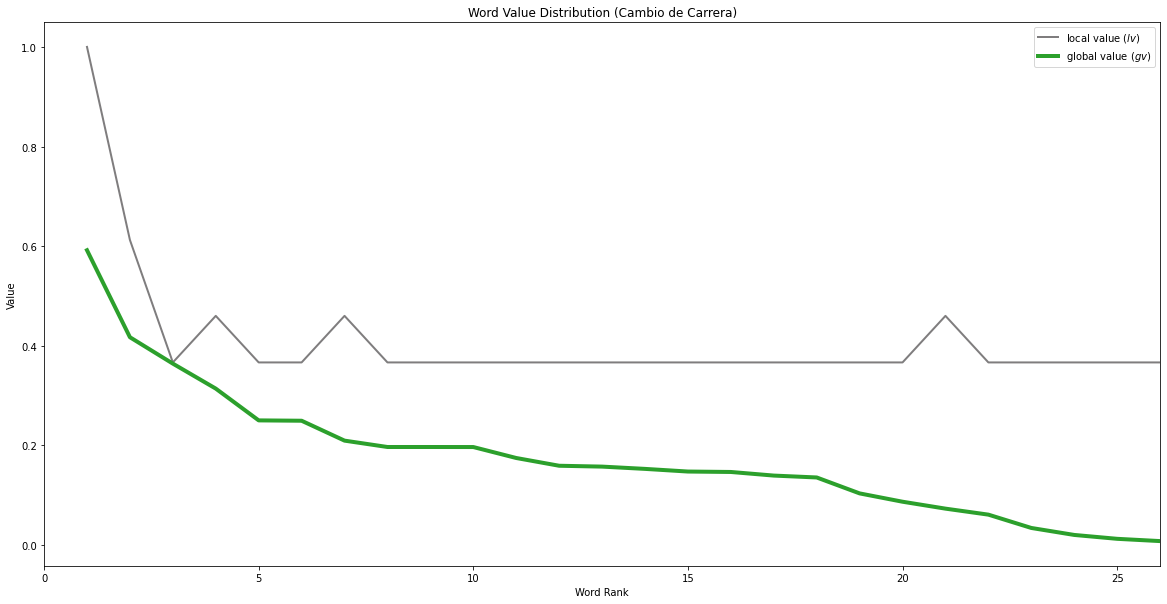

In [11]:
clf.plot_value_distribution('Cambio de Carrera')

### Test Live

Se verifica el __Test Live__:

In [12]:
TEST_LIVE=False

if TEST_LIVE:
  Live_Test.run(clf, test_df['consulta'], test_df['clase'])

### Extracción de _Features_

Se extraen y guardan los términos más representativos por clase.

En primer lugar se genera la carpeta donde se guardan los txt con los términos por clase:

In [13]:
!mkdir txts_ss3

Se genera el vocabulario en txt por cada clase y se guarda en la carpeta __txts_ss3__:

In [14]:
for cat in clf.get_categories():
  print(f'Se genera el txt de la clase {cat}.')
  clf.save_cat_vocab(cat, path='./txts_ss3', n_grams=- 1)

Se genera el txt de la clase Boleto Universitario.
Se genera el txt de la clase Cambio de Carrera.
Se genera el txt de la clase Cambio de Comisión.
Se genera el txt de la clase Consulta por Equivalencias.
Se genera el txt de la clase Consulta por Legajo.
Se genera el txt de la clase Consulta sobre Título Universitario.
Se genera el txt de la clase Cursadas.
Se genera el txt de la clase Datos Personales.
Se genera el txt de la clase Exámenes.
Se genera el txt de la clase Ingreso a la Universidad.
Se genera el txt de la clase Pedido de Certificados.
Se genera el txt de la clase Problemas con la Clave.
Se genera el txt de la clase Reincorporación.
Se genera el txt de la clase Requisitos de Ingreso.
Se genera el txt de la clase Simultaneidad de Carreras.
Se genera el txt de la clase Situación Académica.


In [15]:
! ls txts_ss3

'ss3_vocab_Boleto Universitario(words).csv'
'ss3_vocab_Cambio de Carrera(words).csv'
'ss3_vocab_Cambio de Comisión(words).csv'
'ss3_vocab_Consulta por Equivalencias(words).csv'
'ss3_vocab_Consulta por Legajo(words).csv'
'ss3_vocab_Consulta sobre Título Universitario(words).csv'
'ss3_vocab_Cursadas(words).csv'
'ss3_vocab_Datos Personales(words).csv'
'ss3_vocab_Exámenes(words).csv'
'ss3_vocab_Ingreso a la Universidad(words).csv'
'ss3_vocab_Pedido de Certificados(words).csv'
'ss3_vocab_Problemas con la Clave(words).csv'
'ss3_vocab_Reincorporación(words).csv'
'ss3_vocab_Requisitos de Ingreso(words).csv'
'ss3_vocab_Simultaneidad de Carreras(words).csv'
'ss3_vocab_Situación Académica(words).csv'


## Representación visual del vocabulario

Se genera un _wordcloud_ con los términos presentes en el vocabulario de cada clase y su _CV_:

In [16]:
import pandas as pd

df_clave = pd.read_csv('txts_ss3/ss3_vocab_Problemas con la Clave(words).csv')

df_clave = df_clave[['term', 'cv']]

In [17]:
dict_cv_terms = pd.Series(df_clave.cv.values, index=df_clave.term.values).to_dict()

In [18]:
# Se importan las librerías gráficas
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cloud(wordcloud, titulo):
    # Set figure size
    plt.figure(figsize=(10, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    # Titulo
    plt.title(titulo)
    # Muestro el gráfico
    plt.show()

/usr/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/wordcloud/wordcloud.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


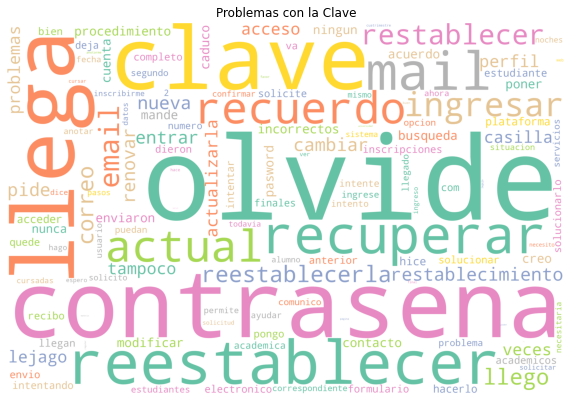

In [19]:
# Genera la wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(dict_cv_terms)
plot_cloud(wordcloud, 'Problemas con la Clave')

Por último se genera el zip con todos los txt y se guarda en Drive:

In [20]:
import shutil
shutil.make_archive('txts_ss3', 'zip', 'txts_ss3')

ENTORNO='Colab'
if ENTORNO=='Colab':
  from google.colab import drive
  drive.mount('drive')
  !cp txts_ss3.zip "drive/My Drive/Tesis_Maestria/outputs/feature_selections_terms/"

Mounted at drive


## Referencias
- https://pyss3.readthedocs.io/en/latest/